### Word Embeddings

- We'll be using the [pymagnitude](https://github.com/plasticityai/magnitude) library

In [1]:
from pymagnitude import *

ModuleNotFoundError: No module named 'torch'

In [9]:
#path = 'data/fasttext-wiki-news-300d-1M.magnitude'
path = 'data/glove.6B.50d.magnitude'
#path = 'data/GoogleNews-vectors-negative300.magnitude'
# this isn't working: path = 'data/elmo_2x4096_512_2048cnn_2xhighway_weights.magnitude'

vectors = Magnitude(path)

In [10]:
len(vectors)

400000

In [11]:
vectors.dim # this is how big the vectors are for each word

50

In [12]:
"cat" in vectors

True

In [13]:
for key, vector in vectors[500:510]:
    print(key, vector[:3])

working [ 0.0547345 -0.0305866 -0.0075621]
community [ 0.0276732  0.117468  -0.1533174]
eight [0.0133356 0.0815326 0.1307856]
groups [ 0.0933181 -0.0622403 -0.0163335]
despite [-0.0066614  0.0074928 -0.0322814]
level [-0.0736265  0.1976634  0.0354784]
largest [0.1119611 0.0235172 0.0475007]
whose [ 0.0633574  0.144303  -0.0080723]
attacks [ 0.2780417 -0.1416092  0.1276424]
germany [0.0529495 0.009489  0.0464709]


In [14]:
vectors.query("cat")[:3]

array([ 0.1027278, -0.1136787, -0.1218595], dtype=float32)

In [15]:
vectors.query(["cat","dog"])[0][:3]

array([ 0.1027278, -0.1136787, -0.1218595], dtype=float32)

In [16]:
vectors.distance("cat", "dog")

0.395473

In [17]:
vectors.distance("cat", "car")

1.1279846

In [18]:
vectors.most_similar_to_given("cat", ["dog", "television", "laptop"]) 

'dog'

In [19]:
vectors.doesnt_match(["breakfast", "cereal", "dinner", "lunch"])

'cereal'

In [20]:
#vectors.most_similar("cat", topn = 5)

In [21]:
#vectors.most_similar(positive = ["woman", "king"], negative = ["man"])

### Topic Modeling

- Given a document, determine the topic of the document
- For this task, we'll use the Brown corpus of texts accessible via NLTK

In [23]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\gcara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

In [24]:
from nltk.corpus import brown
from collections import defaultdict
import tqdm # tqdm displays a progress bar
from tqdm import tqdm_notebook as tqdm

category_vectors = []

cats = brown.categories()
    
# for each category
for cat in cats:
    print(cat)
    # grab all of the documents
    for fileid in tqdm(brown.fileids(categories=[cat])):
        words = list(map(str.lower, brown.words(fileids=[fileid])))
        # grab all of the words, find their embedding, sum all embeddings
        word_sum = np.sum([vectors.query([w]) for w in words if w in vectors], axis=0) # why axis=0?
        # add the now summed embedding to the list for this category
        category_vectors.append((cat,word_sum))
    

adventure



belles_lettres



editorial



fiction



government



hobbies



humor



learned



lore



mystery



news



religion



reviews



romance



science_fiction


In [25]:
import pandas as pd

keys,values=zip(*category_vectors) # unzip using a *

data = pd.DataFrame({'cat':keys,'vectors':values})

In [26]:
data[:3]

,cat,vectors
0,adventure,"[[101.48395, 49.925434, -35.528347, -92.13484,..."
1,adventure,"[[93.14879, 49.615086, -33.30255, -89.50236, 1..."
2,adventure,"[[93.08724, 25.093605, 1.5583314, -87.50236, 1..."


In [27]:
total = len(data)

#### compute the baselines

In [28]:
print('random baseline {}'.format(1.0/len(cat)))

print('most common baseline?')
for cat in cats:
    print(cat, len(data[data.cat==cat])/total)

random baseline 0.06666666666666667
most common baseline?
adventure 0.058
belles_lettres 0.15
editorial 0.054
fiction 0.058
government 0.06
hobbies 0.072
humor 0.018
learned 0.16
lore 0.096
mystery 0.048
news 0.088
religion 0.034
reviews 0.034
romance 0.058
science_fiction 0.012


#### split the data into train/test

In [29]:
test = data.sample(frac=0.1,random_state=200)
train = data.drop(test.index)

test.shape, train.shape 

((50, 2), (450, 2))

In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le.fit(data.cat) 
y = le.transform(train.cat).reshape(-1, 1) # this is magic
ohe.fit(y)
y = ohe.transform(y)

X = np.array([x[0] for x in train.vectors])

X.shape, y.shape

((450, 50), (450, 15))

#### train a classifier

In [50]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [83]:
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=vectors.dim))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=len(cats), activation='softmax'))

In [84]:
adam = Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [85]:
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [86]:
history = model.fit(X,y, epochs=100, batch_size=100)

Epoch 1/100
450/450 [==============================] - ETA: 1s - loss: 1.9877 - acc: 0.876 - 0s 960us/step - loss: 2.0091 - acc: 0.8747
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 2.0519 - acc: 0.872 - 0s 35us/step - loss: 2.0091 - acc: 0.8747
Epoch 3/100
450/450 [==============================] - ETA: 0s - loss: 2.0946 - acc: 0.869 - 0s 40us/step - loss: 2.0091 - acc: 0.8747
Epoch 4/100
450/450 [==============================] - ETA: 0s - loss: 1.9877 - acc: 0.876 - 0s 40us/step - loss: 2.0091 - acc: 0.8747
Epoch 5/100
450/450 [==============================] - ETA: 0s - loss: 2.0091 - acc: 0.874 - 0s 55us/step - loss: 2.0091 - acc: 0.8747
Epoch 6/100
450/450 [==============================] - ETA: 0s - loss: 1.9450 - acc: 0.878 - 0s 40us/step - loss: 2.0091 - acc: 0.8747
Epoch 7/100
450/450 [==============================] - ETA: 0s - loss: 1.9450 - acc: 0.878 - 0s 38us/step - loss: 2.0091 - acc: 0.8747
Epoch 8/100
450/450 [==============================] -

450/450 [==============================] - ETA: 0s - loss: 2.0519 - acc: 0.872 - 0s 33us/step - loss: 2.0091 - acc: 0.8747
Epoch 62/100
450/450 [==============================] - ETA: 0s - loss: 2.0519 - acc: 0.872 - 0s 29us/step - loss: 2.0091 - acc: 0.8747
Epoch 63/100
450/450 [==============================] - ETA: 0s - loss: 2.0091 - acc: 0.874 - 0s 35us/step - loss: 2.0091 - acc: 0.8747
Epoch 64/100
450/450 [==============================] - ETA: 0s - loss: 1.9450 - acc: 0.878 - 0s 29us/step - loss: 2.0091 - acc: 0.8747
Epoch 65/100
450/450 [==============================] - ETA: 0s - loss: 2.0091 - acc: 0.874 - 0s 35us/step - loss: 2.0091 - acc: 0.8747
Epoch 66/100
450/450 [==============================] - ETA: 0s - loss: 2.0732 - acc: 0.870 - 0s 31us/step - loss: 2.0091 - acc: 0.8747
Epoch 67/100
450/450 [==============================] - ETA: 0s - loss: 2.0091 - acc: 0.874 - 0s 31us/step - loss: 2.0091 - acc: 0.8747
Epoch 68/100
450/450 [==============================] - ETA: 

dict_keys(['loss', 'acc'])


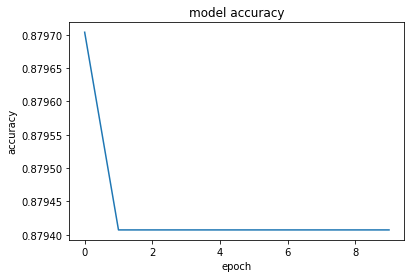

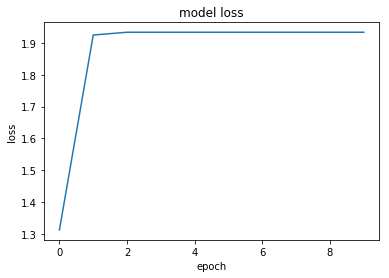

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

dict_keys(['loss', 'acc'])


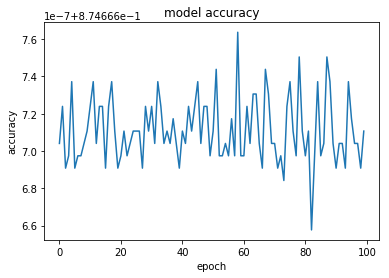

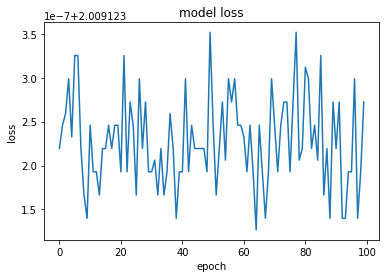

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### evaluate 

In [36]:
from sklearn.metrics import accuracy_score

In [62]:
test_y = ohe.transform(le.transform(test.cat).reshape(-1, 1))

test_X = np.array([x[0] for x in test.vectors])

model.evaluate(test_X, test_y)

50/50 [==============================] - ETA:  - 0s 1ms/step


[1.4202947092056275, 0.872000002861023]

### Embeddings with `flair` library

- [reference](https://github.com/zalandoresearch/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md)
- flair can use your GPU if you have CUDA installed

In [38]:
from flair.embeddings import WordEmbeddings

# init embedding
glove_embedding = WordEmbeddings('glove')

ModuleNotFoundError: No module named 'flair'

In [4]:
from flair.data import Sentence
# create sentence.
sentence = Sentence('The grass is green .')

# embed a sentence using glove.
glove_embedding.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding[:10])

Token: 1 The
tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875])
Token: 2 grass
tensor([-0.8135,  0.9404, -0.2405, -0.1350,  0.0557,  0.3363,  0.0802, -0.1015,
        -0.5478, -0.3537])
Token: 3 is
tensor([-0.5426,  0.4148,  1.0322, -0.4024,  0.4669,  0.2182, -0.0749,  0.4733,
         0.0810, -0.2208])
Token: 4 green
tensor([-6.7907e-01,  3.4908e-01, -2.3984e-01, -9.9652e-01,  7.3782e-01,
        -6.5911e-04,  2.8010e-01,  1.7287e-02, -3.6063e-01,  3.6955e-02])
Token: 5 .
tensor([-0.3398,  0.2094,  0.4635, -0.6479, -0.3838,  0.0380,  0.1713,  0.1598,
         0.4662, -0.0192])


In [6]:
from flair.embeddings import BertEmbeddings

# init embedding
embedding = BertEmbeddings()

# create a sentence
sentence = Sentence('The grass is green .')

# embed words in sentence
embedding.embed(sentence)

RuntimeError: CUDA error: out of memory